# Generating Lego Minifigures using Convolutional Variational Autoencoder

# Setup (RUN THIS)

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image     
import sys    
import tqdm
import pathlib

from IPython import display

import numpy as np
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import sklearn.datasets
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, UpSampling2D, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import Accuracy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import pandas as pd

# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/MyDrive/ANN_LEGO_Project'

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1f5ywnb0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-1f5ywnb0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179812 sha256=e5bfe1ab96c06ca737d5d5840884f8ed41fd7fc1c520e8b7ab2ef6e90dd1b019
  Stored in directory: /tmp/pip-ephem-wheel-cache-fscase9g/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1cld6GJyRl12EO6UgrLfN5-BmG593PmLQ/ANN_LEGO_Project


# Data Input & Preprocessing (DO NOT RERUN THIS)

In [ ]:
!unzip 'minifigures/minifigures.zip'

Streaming output truncated to the last 5000 lines.
  inflating: minifigures/4995.jpg    
  inflating: minifigures/4998.jpg    
  inflating: minifigures/4990.jpg    
  inflating: minifigures/5013.jpg    
  inflating: minifigures/4999.jpg    
  inflating: minifigures/4991.jpg    
  inflating: minifigures/4988.jpg    
  inflating: minifigures/4987.jpg    
  inflating: minifigures/4984.jpg    
  inflating: minifigures/4992.jpg    
  inflating: minifigures/4985.jpg    
  inflating: minifigures/4983.jpg    
  inflating: minifigures/4986.jpg    
  inflating: minifigures/4975.jpg    
  inflating: minifigures/4979.jpg    
  inflating: minifigures/4974.jpg    
  inflating: minifigures/4993.jpg    
  inflating: minifigures/4981.jpg    
  inflating: minifigures/4982.jpg    
  inflating: minifigures/4978.jpg    
  inflating: minifigures/4970.jpg    
  inflating: minifigures/4972.jpg    
  inflating: minifigures/4976.jpg    
  inflating: minifigures/4964.jpg    
  inflating: minifigures/4989.jpg    

In [ ]:
#This creates the padded images?

path_original = "minifigures/"
path_preprocessed = "dataset_preprocessed/minifigures/"

dirs = os.listdir(path_original)                                       

def add_margin_resize(newsize=(80, 80)):
    count = 0
    for img_file in dirs:
        if img_file == ".DS_Store":
            continue

        img = Image.open(os.path.join(path_original, img_file))
        img = img.convert('RGB')

        width, height = img.size

        if height > width:
            right = left = int((height-width)/2)
            top = bottom = 0 

        else:
            top = bottom = int((width-height)/2)
            left = right = 0

        new_width = width + right + left
        new_height = height + top + bottom

        img_square = Image.new(img.mode, (new_width, new_height), (255, 255, 255))
        img_square.paste(img, (left, top))

        img_square_resized = img_square.resize(newsize)

        img_square_resized.save('/dataset_preprocessed/minifigures/{0}.jpg'.format(count), quality=100)

        if count % 100 == 0:
            print(path_preprocessed + str(count) + '.jpg')

        count += 1

        break

add_margin_resize()

FileNotFoundError: ignored

# TF Dataset (RUN THIS)

In [20]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'dataset_preprocessed',
            label_mode=None,
            batch_size=None,
            image_size=(80, 80),
            shuffle=True)

Found 8583 files belonging to 1 classes.


In [21]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = len(dataset)
AUTOTUNE = tf.data.experimental.AUTOTUNE
dims = (80,80)

# Use this function to normalize your images.
def tf_norm_image(image, resize_dim=(80, 80)):
    """Normalizes image to [0.,1.] and resizes to `resize_dim`, returning an image tensor."""
    image = image/255.
    return (image, image)

#############
# Train data
#############
dataset = dataset.map(tf_norm_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=AUTOTUNE)
# # Change to speed up trianing in 5.4:
# train_ds = train_ds.shuffle(buffer_size=1024)
# train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

print("dataset", dataset)

dataset <PrefetchDataset element_spec=(TensorSpec(shape=(32, 80, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 80, 80, 3), dtype=tf.float32, name=None))>


In [22]:
print(f' Dataset format: {dataset}')
print(f' Dataset cardinality: {int(dataset.cardinality())} batches')

 Dataset format: <PrefetchDataset element_spec=(TensorSpec(shape=(32, 80, 80, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 80, 80, 3), dtype=tf.float32, name=None))>
 Dataset cardinality: 268 batches


## Create AE

In [23]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input image dimensions.
        -dropout_rate: if dropout layers present.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        act_down = {"kernel_size": (5,5), 
                    "activation": 'relu', 
                    "strides": (2,2), 
                    "padding": 'same'}
        
        self.encoder = Sequential([
            Conv2D(9, input_shape = input_shape, **act_down),   #40x40x9
            Conv2D(18, input_shape = input_shape, **act_down),  #20x20x18
            Conv2D(32, input_shape = input_shape, **act_down),  #10x10x32
            Conv2D(64, input_shape = input_shape, **act_down)]) #5x5x64
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        
        z = self.encoder(inputs, training = training)
        
        return z

In [24]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        -dropout_rate: if dropout layers present.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        self.dropout_rate = dropout_rate
        
        # your code here
        
        act_up = {"activation" : 'relu',
                  "kernel_size": (5,5),
                  "strides": (1,1),
                  "padding": 'same' }
        
        upsamp_args = {'size' : (2,2), 
                       'interpolation': 'nearest'}

        self.decoder = Sequential([
            Input(shape = latent_dim),    #5x5x64
            UpSampling2D(**upsamp_args),  #10x10x64
            Conv2D(64, **act_up),         #10x10x64
            UpSampling2D(**upsamp_args),  #20x80x64
            Conv2D(32, **act_up),         #20x80x32
            UpSampling2D(**upsamp_args),  #40x80x32
            Conv2D(18, **act_up),         #40x80x18
            UpSampling2D(**upsamp_args),  #80x80x18
            Conv2D(3, activation = "sigmoid",
                             kernel_size = (1,1),
                             strides = (1,1),
                             padding = "same")]) #80x80x3
                
    def call(self, z, training=None):
        
        x = self.decoder(z, training = training)
        
        return x

In [75]:
input_shape = (80,80,3)
latent_dim = (5, 5, 64)
bottleneck_dim = 256

input_AE = Input(shape = input_shape)
x = ConvEncoder(input_shape = input_shape)(input_AE)

x = Flatten()(x)
z_AE = Dense(bottleneck_dim, activation = 'linear')(x)

# Create Encoder_AE
Encoder_AE = Model(inputs = input_AE, outputs = z_AE, name = "Encoder_AE")
Encoder_AE.summary()

x = Dense(np.prod(latent_dim), activation = "relu")(z_AE)
x = layers.Reshape(latent_dim)(x)

output_AE = ConvDecoder(input_shape = latent_dim)(x)

# Create Decoder_AE
Decoder_AE = Model(inputs = z_AE, outputs = output_AE, name = "Decoder_AE")

# Create AE
AE = Model(inputs = input_AE, outputs = output_AE, name = "AE")

Model: "Encoder_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 encoder (ConvEncoder)       (None, 5, 5, 64)          70448     
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               409856    
                                                                 
Total params: 480,304
Trainable params: 480,304
Non-trainable params: 0
_________________________________________________________________


In [76]:
EPOCHS = 5
MODEL_DIR = 'models/'
AE_TRAINED = False

if not AE_TRAINED:
    AE.compile(optimizer = optimizers.Adam(), loss = losses.MeanSquaredError())
    history = AE.fit(dataset,
                     epochs=EPOCHS)
    
    #save the model
    AE.save(MODEL_DIR + 'AE')
else:
    #load the model
    AE = tf.keras.models.load_model(MODEL_DIR + 'AE')
    
AE.summary()

Epoch 1/5
268/268 [==============================] - 8s 11ms/step - loss: 0.0359
Epoch 2/5
268/268 [==============================] - 7s 11ms/step - loss: 0.0205
Epoch 3/5
268/268 [==============================] - 7s 11ms/step - loss: 0.0158
Epoch 4/5
268/268 [==============================] - 7s 11ms/step - loss: 0.0142
Epoch 5/5
268/268 [==============================] - 8s 11ms/step - loss: 0.0132
INFO:tensorflow:Assets written to: models/AE/assets
Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 encoder (ConvEncoder)       (None, 5, 5, 64)          70448     
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 de

In [77]:
def display_imgs_reconstructed(ds, model, n_imgs=5):
    
    # take a sample of n_imgs tuples and convert to list for indexing:
    elements = list(ds.unbatch().shuffle(100).take(n_imgs))
    # each element is formatted as tuple: (img, img)
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 2, figsize = (8,4))
        
        # extract and display original image
        original_img = elements[i][0].numpy()

        ax[0].imshow(original_img)

        try:
            #if the model is convolutional then this case will execute
            img4d = tf.expand_dims(original_img, axis = 0)
            reconstructed_img = model.predict(img4d)
        except:
            #otherwise this case will execute
            img = tf.reshape(original_img, shape = (80*80*3,))
            img2d = tf.expand_dims(img, axis = 0)
            reconstructed_img = model.predict(img2d)

        reconstructed_img = tf.reshape(reconstructed_img, shape = (80,80,3))

        ax[1].imshow(reconstructed_img)

        titles = ['original image', 'reconstructed image']

        [ax[i].set_title(title) for i, title in enumerate(titles)]

        [ax[i].axis('off') for i in range(2)]

        plt.show()

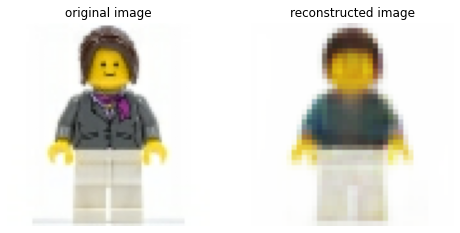

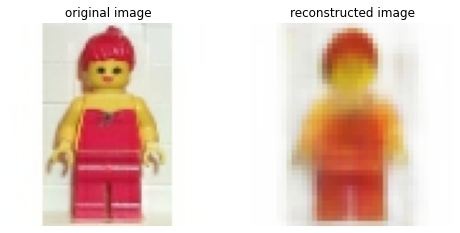

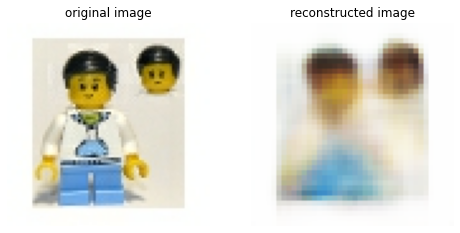

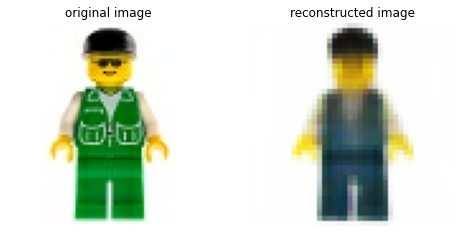

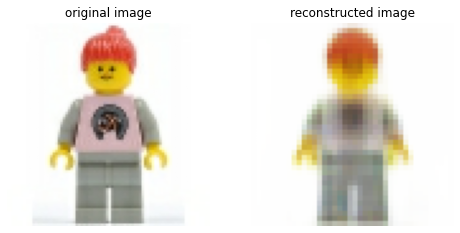

In [78]:
display_imgs_reconstructed(dataset, AE, n_imgs=5)

## Generate new minifigures by integrating random noise into the existing latent space representations

In [79]:
rand_noise = np.random.uniform(0, .5, size=(32,bottleneck_dim))

In [98]:
latent_representations_AE = Encoder_AE.predict(dataset.take(1))

In [99]:
latent_representations_AE

array([[ 0.16606514,  0.0976524 ,  0.3605979 , ..., -0.10003613,
        -0.33538482, -0.3437947 ],
       [-0.22045441, -0.04058286,  0.22595093, ...,  0.08113286,
         0.20406795, -0.0551427 ],
       [-0.03191965, -0.4315252 , -0.32919925, ...,  0.39506912,
        -0.5350237 , -0.31381935],
       ...,
       [-0.05827444,  0.11966868,  0.02755386, ...,  0.24139835,
         0.74993616,  0.4953972 ],
       [-0.22053142,  0.08446077,  0.31717074, ...,  0.18131422,
        -0.5553784 ,  0.70364857],
       [-0.31192243,  0.2094612 , -0.07752325, ..., -0.30657727,
        -0.32064703,  0.3062446 ]], dtype=float32)

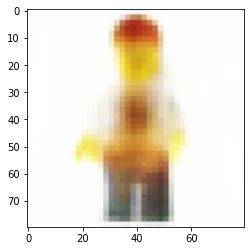

In [97]:
plt.imshow(Decoder_AE.predict(latent_representations_AE + np.random.normal(loc=0.0, scale=.5, size=(32, bottleneck_dim)))[15])

## Attempting to generate images from random noise using AE

Doesn't work because the latent representations aren't regularized.

In [212]:
random_noise = np.random.normal(0, 1, size=(32, bottleneck_dim))

In [213]:
reconstructed_imgs_AE = Decoder_AE.predict(random_noise)

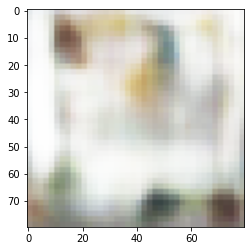

In [214]:
plt.imshow(reconstructed_imgs_AE[20])

In [277]:
def display_noise_reconstructed(decoder_model, model_name, n_images=5):

    random_noise = np.random.normal(0, 1, size=(32, bottleneck_dim))
    reconstructed_noise = decoder_model.predict(random_noise)

    fig, ax = plt.subplots(1, n_images, figsize = (18,8))

    for i in np.arange(0, n_images):
        ax[i].imshow(reconstructed_noise[i])
        ax[i].axis('off')
        ax[i].set_title(f"{model_name} reconstruction \nfrom noise #{i+1}")
    plt.tight_layout()
    plt.show()

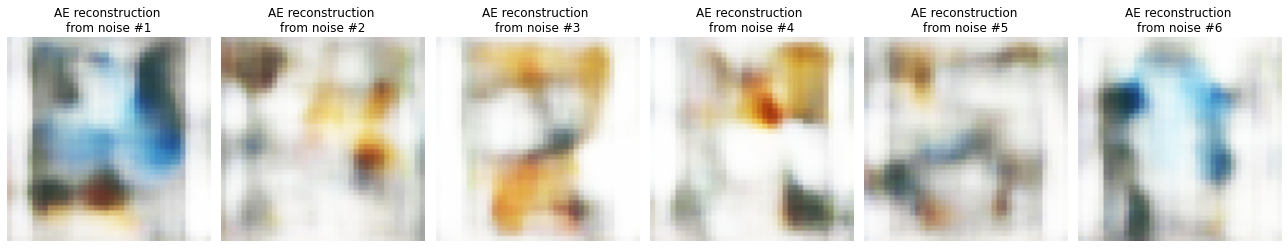

In [286]:
display_noise_reconstructed(Decoder_AE, "AE", 6)

## Plot latent representation from AE

In [220]:
def get_latent_representation_PCA(Encoder_model, ds_sample):
    latent_representations = Encoder_model.predict(ds_sample)
    
    pca = None
    del pca
    pca = PCA(n_components=2)
    
    pca_result = None
    del pca_result
    pca_result = pca.fit_transform(latent_representations)
    
    return pca, pca_result

In [238]:
def get_latent_representation_TSNE(Encoder_model, ds_sample):
    latent_representations = Encoder_model.predict(ds_sample)

    tsne = None
    del tsne
    tsne = TSNE(n_components=2, init = 'pca')
    
    tsne_result = None
    del tsne_result
    tsne_result = tsne.fit_transform(latent_representations)

    return tsne_result

In [249]:
def plot_latent_representation_PCA(pca, latent_representation_pca, model_name):
    
    fig, ax = plt.subplots(figsize=(9, 9)) 

    ax.scatter(
            latent_representation_pca[:,0],
            latent_representation_pca[:,1],
            s=12,
            alpha=0.6)
    ax.grid(":", alpha=0.4)
    ax.set_xlabel("First Principal Component", fontsize=12)
    ax.set_ylabel("Second Principal Component", fontsize=12)
    ax.set_title(f"Visualization of latent representation from {model_name} of a sample of images using \n top 2 principal components. Variance explained: {np.sum(pca.explained_variance_ratio_)*100:.3f}%")

    plt.tight_layout()
    plt.show()

In [250]:
def plot_latent_representation_TSNE(latent_representation_tsne, model_name):

    fig, ax = plt.subplots(figsize=(9, 9)) 

    ax.scatter(
            latent_representation_tsne[:,0],
            latent_representation_tsne[:,1],
            s=12,
            alpha=0.6)
    ax.grid(":", alpha=0.4)
    ax.set_xlabel("First TSNE Component", fontsize=12)
    ax.set_ylabel("Second TSNE Component", fontsize=12)
    ax.set_title(f"Visualization of latent representation from {model_name} of validation images using 2 TSNE components")

    plt.tight_layout()
    plt.show()

In [244]:
ds_sample = dataset.take(32)

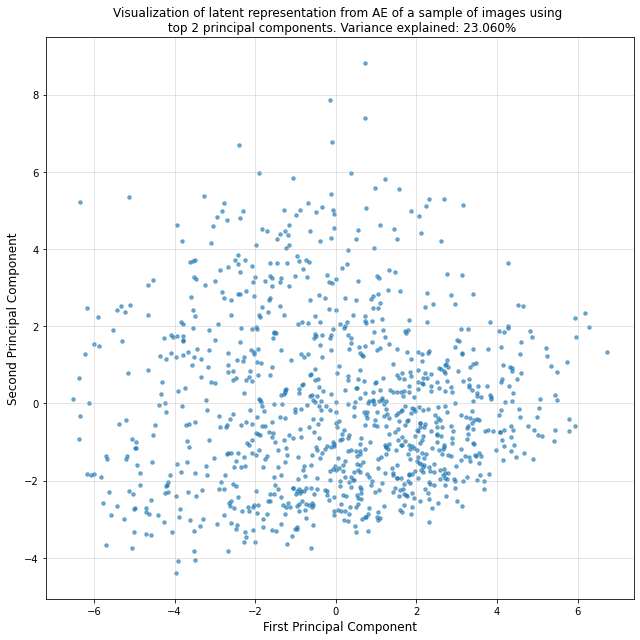

In [251]:
pca_AE, latent_representation_PCA_AE = get_latent_representation_PCA(Encoder_AE, ds_sample)
plot_latent_representation_PCA(pca_AE, latent_representation_PCA_AE, "AE")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


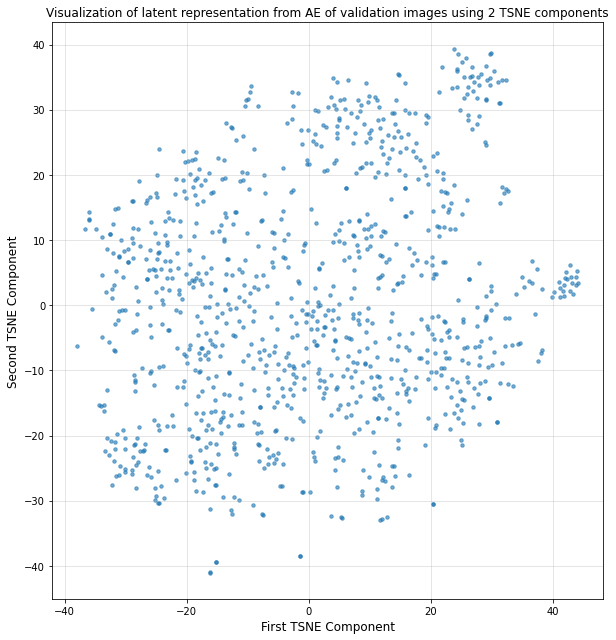

In [252]:
latent_representation_TSNE_AE = get_latent_representation_TSNE(Encoder_AE, ds_sample)
plot_latent_representation_TSNE(latent_representation_TSNE_AE, "AE")

## Create VAE

In [197]:
class Sampling(layers.Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs): 
        """Returns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        batch, dim = tf.shape(z_mean)[0], tf.shape(z_mean)[1]
        epsilon = tf.random.normal((batch, dim), mean = 0, stddev = 1)
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

In [198]:
input_shape = (80,80,3)
latent_dim = (5, 5, 64)
bottleneck_dim = 256
EPOCHS = 10

In [199]:
input_VAE = Input(shape = input_shape)
x = ConvEncoder(input_shape = input_shape)(input_VAE)
############################### the embedding space starts here
x = Flatten()(x)
# Reparametrization, source of stochasticity
mu_VAE = Dense(bottleneck_dim, activation = "linear", name="z_mean")(x)
logvariance_VAE = Dense(bottleneck_dim, activation = "linear", name="z_log_var")(x)

normal_draws_VAE = Sampling()((mu_VAE, logvariance_VAE))

Encoder_VAE = Model(inputs = input_VAE, outputs = normal_draws_VAE, name = "Encoder_VAE")
Encoder_VAE.summary()

x = Dense(np.prod(latent_dim), activation = "relu")(normal_draws_VAE)
x = layers.Reshape(latent_dim)(x)
############################## end embedding space
output_VAE = ConvDecoder(input_shape = latent_dim)(x)

Decoder_VAE = Model(inputs = normal_draws_VAE, outputs = output_VAE, name = "Decoder_VAE")

VAE = Model(inputs = input_VAE, outputs = output_VAE, name = "VAE")

# Create custom KL layer
class KL(layers.Layer):
    def call(self, inputs, reg = .1):
        z_mean, z_log_var = inputs
        
        kl_loss = - reg * 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        return kl_loss
    
KL_Layer_VAE = KL()((mu_VAE, logvariance_VAE), reg=.1)

Model: "Encoder_VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 encoder (ConvEncoder)          (None, 5, 5, 64)     70448       ['input_39[0][0]']               
                                                                                                  
 flatten_13 (Flatten)           (None, 1600)         0           ['encoder[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 256)          409856      ['flatten_13[0][0]']             
                                                                                        

In [200]:
VAE_TRAINED = True

if not VAE_TRAINED:
    VAE.compile(optimizer = optimizers.Adam(), loss = losses.MeanSquaredError())
    VAE.add_loss(KL_Layer_VAE)
    history = VAE.fit(dataset,
                       epochs=EPOCHS)
    #save the model
    VAE.save(MODEL_DIR + 'VAE')
else:
    #load the model
    VAE = tf.keras.models.load_model(MODEL_DIR + 'VAE')
    
VAE.summary()

Epoch 1/10
268/268 [==============================] - 8s 11ms/step - loss: 0.0454
Epoch 2/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0338
Epoch 3/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0327
Epoch 4/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0321
Epoch 5/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0314
Epoch 6/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0307
Epoch 7/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0301
Epoch 8/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0292
Epoch 9/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0284
Epoch 10/10
268/268 [==============================] - 7s 11ms/step - loss: 0.0280
INFO:tensorflow:Assets written to: models/VAE/assets
Model: "VAE"
__________________________________________________________________________________________________
 Layer (type) 

In [201]:
def display_img_reconstructed(img, model, model_name, n_replications=5):
    fig, ax = plt.subplots(1, n_replications, figsize = (18,8))
    for i in np.arange(0, n_replications):
        try:
            #if the model is convolutional then this case will execute
            img4d = tf.expand_dims(img, axis = 0)
            reconstructed_img = model.predict(img4d)
        except:
            #otherwise this case will execute
            img = tf.reshape(img, shape = (80*80*3,))
            img2d = tf.expand_dims(img, axis = 0)
            reconstructed_img = model.predict(img2d)

        reconstructed_img = tf.reshape(reconstructed_img, shape = (80,80,3))

        ax[i].imshow(reconstructed_img)
        ax[i].axis('off')
        ax[i].set_title(f"{model_name} reconstruction #{i+1}")
    plt.tight_layout()
    plt.show()

In [202]:
original_img = list(dataset.unbatch().shuffle(100).take(1))[0][0].numpy()

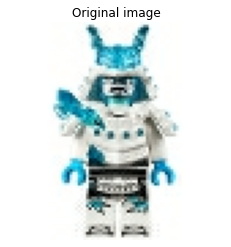

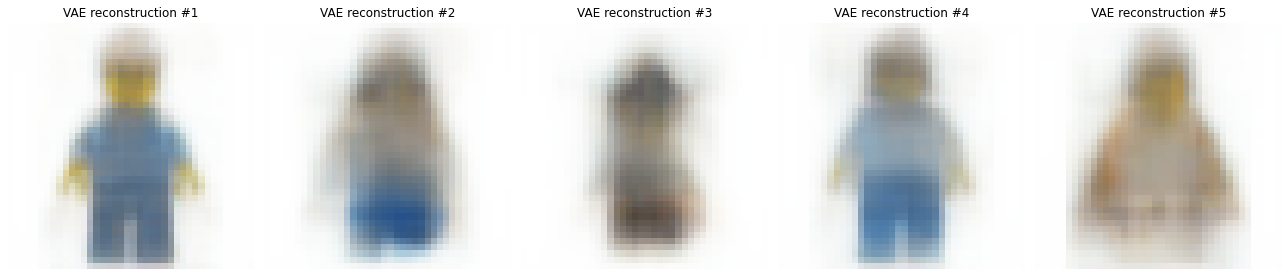

In [203]:
plt.imshow(original_img)
plt.title("Original image")
plt.axis('off')
display_img_reconstructed(original_img, VAE, "VAE", n_replications=5)
plt.show()

## Generate new minifigures with VAE

In [216]:
reconstructed_imgs_VAE = Decoder_VAE.predict(random_noise)

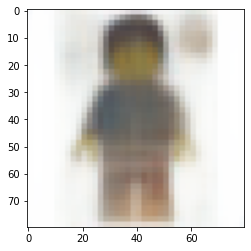

In [217]:
plt.imshow(reconstructed_imgs_VAE[20])

In [270]:
def display_noise_reconstructed(decoder_model, model_name, n_images=5):

    random_noise = np.random.normal(0, 1, size=(32, bottleneck_dim))
    reconstructed_noise = decoder_model.predict(random_noise)

    fig, ax = plt.subplots(1, n_images, figsize = (18,8))

    for i in np.arange(0, n_images):
        ax[i].imshow(reconstructed_noise[i])
        ax[i].axis('off')
        ax[i].set_title(f"{model_name} reconstruction \nfrom noise #{i+1}")
    plt.tight_layout()
    plt.show()

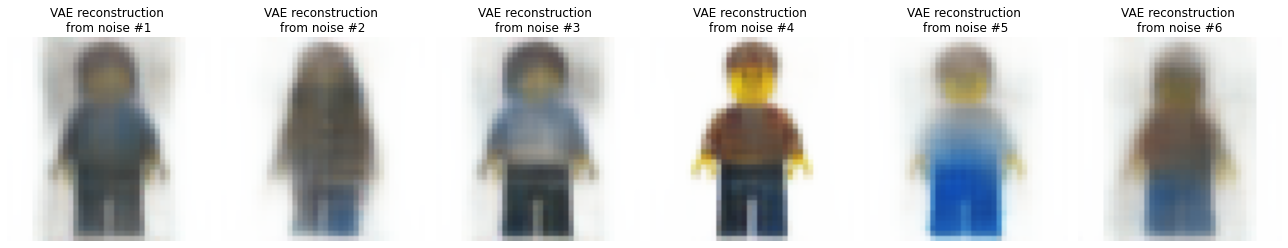

In [285]:
display_noise_reconstructed(Decoder_VAE, "VAE", 6)

## Plot latent representations from VAE

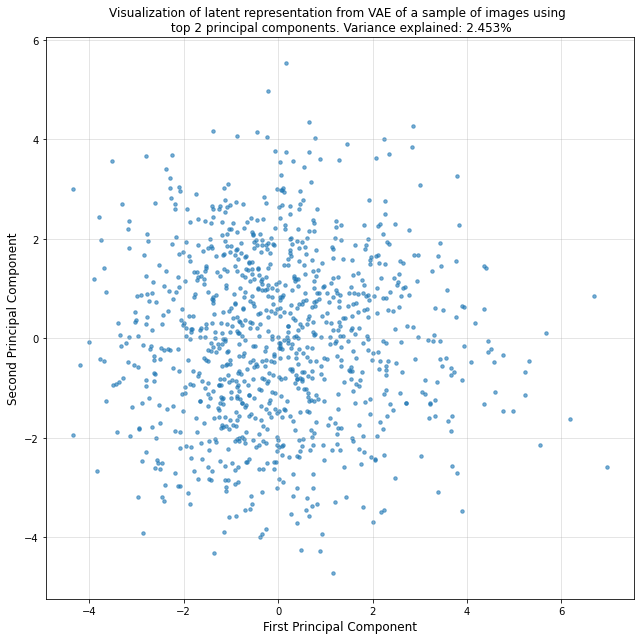

In [253]:
pca_VAE, latent_representation_PCA_VAE = get_latent_representation_PCA(Encoder_VAE, ds_sample)
plot_latent_representation_PCA(pca_VAE, latent_representation_PCA_VAE, "VAE")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


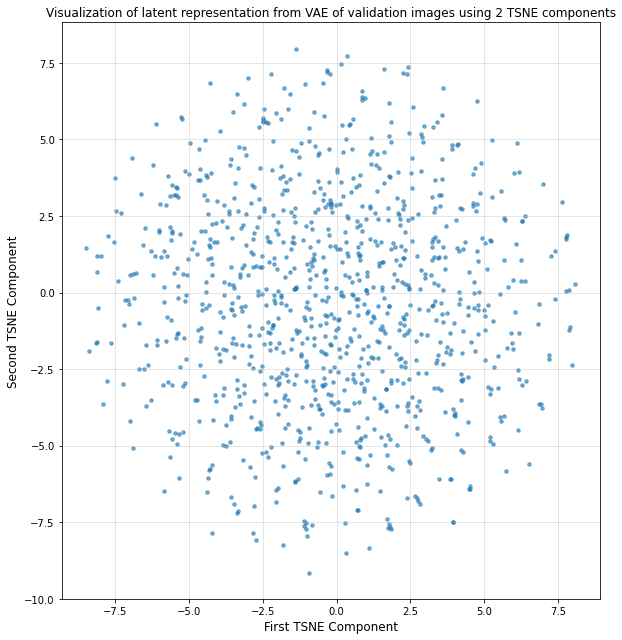

In [254]:
latent_representation_TSNE_VAE = get_latent_representation_TSNE(Encoder_VAE, ds_sample)
plot_latent_representation_TSNE(latent_representation_TSNE_VAE, "VAE")